# Signal processing

In [43]:
import neo
import numpy as np
import quantities as pq
from elephant.signal_processing import zscore, cross_correlation_function
import matplotlib.pyplot as plt

## z-scoring

In [44]:
time = np.arange(0, 2, 0.01)
amplitude = (np.sin(2 * np.pi * time) + np.random.normal(0, 2, len(time))) * pq.mV
signal = neo.AnalogSignal(amplitude.reshape(-1, 1), t_start=0 * pq.s, sampling_rate=100 * pq.Hz)

z_scored_signal = zscore(signal, inplace=False)

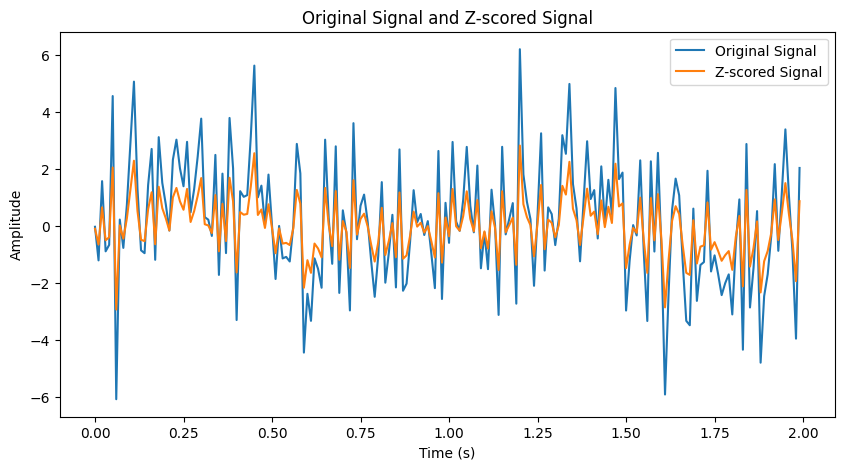

In [45]:
# Plot the original signal
plt.figure(figsize=(10, 5))
plt.plot(signal.times, signal, label='Original Signal')

# Plot the z-scored signal
plt.plot(z_scored_signal.times, z_scored_signal, label='Z-scored Signal')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Signal and Z-scored Signal')
plt.legend()

# Show the plot
plt.show()

## cross-correlation

In [ ]:
# Define parameters
dt = 0.02
n_samples = 2018
frequency = 0.5
time = np.arange(n_samples) * dt

# Generate signals
signal = np.zeros((n_samples, 2))
signal[:, 0] = 0.2 * np.sin(2. * np.pi * frequency * time)
signal[:, 1] = 5.3 * np.cos(2. * np.pi * frequency * time)

# Create neo.AnalogSignalk
signal = neo.AnalogSignal(signal, units='mV', t_start=0.*pq.ms, sampling_rate=1/dt*pq.Hz )

# Compute cross-correlation
rho = cross_correlation_function(signal, [0, 1], n_lags=150)
env = cross_correlation_function(signal, [0, 1], n_lags=150, hilbert_envelope=True)

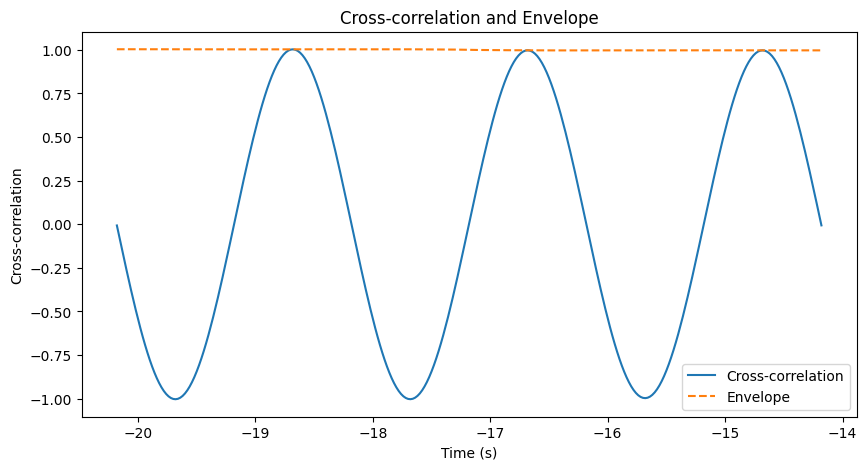

In [47]:
# Plot the cross-correlation and its envelope
plt.figure(figsize=(10, 5))
plt.plot(rho.times, rho, label='Cross-correlation')
plt.plot(env.times, env, label='Envelope', linestyle='--')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation and Envelope')
plt.legend()

# Show the plot
plt.show()